# Clasificación multiclase con redes neuronales (implementación algoritmo retropropagación)
En este ejemplo utilizaremos el algoritmo de retropropagación en redes neuronales para aprender los parámetros de la red y
poder reconocer dígitos escritos a mano.

In [12]:
#Configuraciones iniciales
options(scipen = 999, repr.plot.width=4, repr.plot.height= 4, warn = -1)

In [2]:
#Instalación y carga de paquetes necesarios
list.of.packages <- c('R.matlab', 'fields', 'ggmap', 'gridExtra', 'lbfgsb3')

new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "https://cran.r-project.org")

library(R.matlab)
library(fields)
library(ggmap)
library(gridExtra)
library(lbfgsb3)

R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Loading required package: spam
Loading required package: grid
Spam version 1.4-0 (2016-08-29) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
Loading required package: ggplot2
Loading required package: numDeriv


In [4]:
#Carga de datos
digits <- as.data.frame(readMat('ex3data1.mat')) #valores de los pixeles de los digitos a reconocer
weights <- readMat('ex3weights.mat') #pesos para la red neuronal

X <- as.matrix(digits[, 1:400])
y <- digits[, 401]
Theta1 <- weights[[1]]
Theta2 <- weights[[2]]

str(X)
str(y)
str(Theta1)
str(Theta2)

 num [1:5000, 1:400] 0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:400] "X.1" "X.2" "X.3" "X.4" ...
 num [1:5000] 10 10 10 10 10 10 10 10 10 10 ...
 num [1:25, 1:401] -0.0226 -0.0984 0.1162 -0.2397 -0.7316 ...
 num [1:10, 1:26] -0.761 -0.618 -0.689 -0.678 -0.597 ...


rescaling mat to [0,1]...


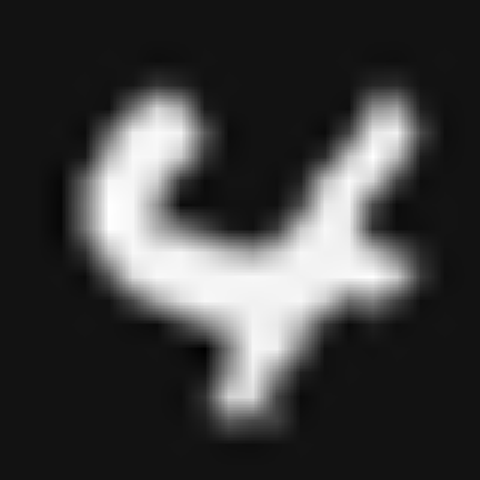

In [15]:
idx <- sample(1:nrow(X), 1)
aux <- matrix(X[idx,], 20, 20)
ggimage(aux, scale_axes = TRUE)

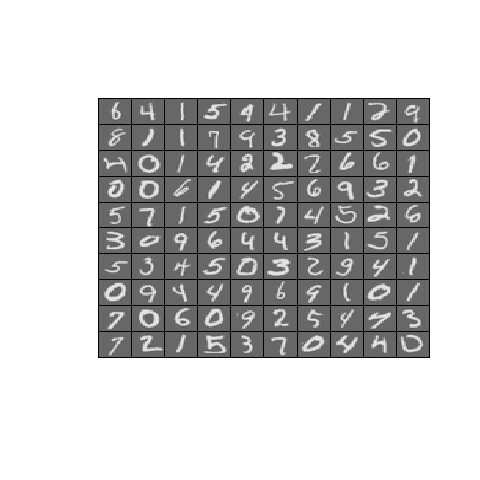

In [16]:
#Visualizamos una muestra del dataset

m <- nrow(X)
rand_indices <- sample(m, 100)
sel <- X[rand_indices, ]

displayData <- function(X) {
    
    
    example_width <- round(sqrt(dim(X)[2]))
    
    if (is.vector(X))
        X <- t(X)
  
    # Calcular número de filas y columnas
    m <- dim(X)[1]
    n <- dim(X)[2]

    example_height <- (n / example_width) #altura en pixeles de c/imagen

    # Cantidad de observaciones a mostrar
    display_rows <- floor(sqrt(m)) #10
    display_cols <- ceiling(m / display_rows) #10
           
    # Espaciado entre dígitos
    pad <- 1

    display_array <- -matrix(0,pad + display_rows * (example_height + pad), pad + display_cols * (example_width + pad))
    curr_ex <- 1

    for (j in 1:display_rows) {
        for (i in 1:display_cols) {
          if (curr_ex > m)
            break
      
          max_val <- max(abs(X[curr_ex,]))
          display_array[pad + (j - 1) * (example_height + pad) + (1:example_height), pad + (i - 1) * (example_width + pad) + 
                        (1:example_width)] <- matrix(unlist(X[curr_ex,]), example_height, example_width) / max_val
          curr_ex <- curr_ex + 1
        }
    
        if (curr_ex > m)
          break
    }

    # Mostrar imagen
    #op <- par(bg = "gray")

    #La imagen se dibuja por fila de abajo a arriba, pero R indexa las matrices por columnas, de arriba a abajo
    dispArr <- t(apply(display_array,2,rev))

    image(z = dispArr, col = gray.colors(100), xaxt = 'n', yaxt = 'n')

    grid(nx = display_cols, display_rows, col = 'black', lwd = 1, lty = 1)
    box()
    #par(op)
    
}
        

displayData(sel)

In [17]:
#Inicializamos algunos parámetros
input_layer_size <- 400
hidden_layer_size <- 25
num_labels <- 10
lambda <- 0

nn_params <- c(c(Theta1), c(Theta2))  #Theta1 y Theta2 dos lo transformamos de matrices a un solo vector para pasar a optim()

In [18]:
#Creamos la función sigmoidal
sigmoid <- function(z) {
  
  g <- 1 / (1 + exp(1) ^ (-z))
}

#Función para calcular el gradiente de la función sigmoidal
sigmoidGradient <- function(z) {
    
    z <- sigmoid(z)
    g  <- z * (1 - z)
    g
}

In [19]:
#Funcion para calcular el costo (con regularización de parámetros)

nnCostFunction <- function(nn_params) {
    
    Theta1 <- matrix(nn_params[1:(hidden_layer_size *(input_layer_size + 1))], hidden_layer_size, input_layer_size +1)
    Theta2 <- matrix(nn_params[(1 + hidden_layer_size * (input_layer_size + 1)):length(nn_params)], 
                     num_labels, hidden_layer_size +1)
    
    Theta1_nz <- Theta1[, 2:ncol(Theta1)]
    Theta2_nz <- Theta2[, 2:ncol(Theta2)]
    
    m <- nrow(X)
    J <- 0
    
    X <- cbind(1, X)
    a1 <- X
    z2 <- a1 %*% t(Theta1)
    a2 <- sigmoid(z2)
    a2 <- cbind(1, a2)
    z3 <- a2 %*% t(Theta2)
    a3 <- sigmoid(z3)
    
    hyp <- a3
    y_mat <- diag(num_labels)
    y_mat <- y_mat[, y]
    
    inner_value <- - t(y_mat) * log(hyp) - (1 - t(y_mat)) * log(1 - hyp)
    J_noreg <- (1/m) * sum(sum(inner_value))
    reg_term <- (lambda / (2 * m)) * sum(sum(sum(Theta1_nz ^ 2)) + sum(sum(Theta2_nz ^ 2)))
    
    J <- J_noreg + reg_term
    
    J
    
}

In [20]:
#Calculamos el costo inicial
J <- nnCostFunction(nn_params)
J

[1] 0.2876292

In [21]:
#Función para calcular los gradientes (con regularización de parámetros)
nnGradFunction <- function(nn_params) {
    
    Theta1 <- matrix(nn_params[1:(hidden_layer_size *(input_layer_size + 1))], hidden_layer_size, input_layer_size +1)
    Theta2 <- matrix(nn_params[(1 + hidden_layer_size * (input_layer_size + 1)):length(nn_params)], 
                     num_labels, hidden_layer_size +1)
    
    Theta1_grad <- matrix(0, ncol = ncol(Theta1), nrow = nrow(Theta1))
    Theta2_grad <- matrix(0, ncol = ncol(Theta1), nrow = nrow(Theta2))
    
    Theta1_nz <- Theta1[, 2:ncol(Theta1)]
    Theta2_nz <- Theta2[, 2:ncol(Theta2)]
    
    m <- nrow(X)
   
    X <- cbind(1, X)
    a1 <- X
    z2 <- a1 %*% t(Theta1)
    a2 <- sigmoid(z2)
    a2 <- cbind(1, a2)
    z3 <- a2 %*% t(Theta2)
    a3 <- sigmoid(z3)
    
    hyp <- a3
    y_mat <- diag(num_labels)
    y_mat <- y_mat[, y]
    
    delta3 <- a3 - t(y_mat)
    z2 <- cbind(1, z2)
    delta2 <- (delta3 %*% Theta2) * sigmoidGradient(z2)
    delta2 <- delta2[, 2:ncol(delta2)]
    
    cap_delta1 <- 0
    cap_delta2 <- 0
    
    cap_delta1 <- cap_delta1 + t(delta2) %*% a1
    cap_delta2 <- cap_delta2 + t(delta3) %*% a2
    
    Theta1[, 1] <- 0
    Theta2[, 1] <- 0
    
    Theta1_grad <- (1 / m) * (cap_delta1 + lambda * Theta1)
    Theta2_grad <- (1 / m) * (cap_delta2 + lambda * Theta2)
    
    grad <- c(c(Theta1_grad), c(Theta2_grad))
}

In [22]:
#Calculamos los gradientes iniciales
grad <- nnGradFunction(nn_params)

length(grad)
head(grad)

[1] 10285

[1]  0.00006187128  0.00009387981 -0.00019259361 -0.00016849457  0.00034868276
[6]  0.00023050523

In [23]:
#Entrenamiento de la red neuronal----------------------------------------------------

#Inicializamos los parámetros de manera aleatoria
randInitializeWeights <- function(L_in, L_out) {
    
    W <- matrix(0, L_out, 1 + L_in)
    epsilon_init <- 0.12
  
    rnd <- runif(L_out * (1 + L_in))
    rnd <- matrix(rnd,L_out,1 + L_in)
    W <- rnd * 2 * epsilon_init - epsilon_init
    W
}

initial_Theta1 <- randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 <- randInitializeWeights(hidden_layer_size, num_labels)

initial_nn_params <- c(c(initial_Theta1), c(initial_Theta2))

In [24]:
lambda <- 1
J <- nnCostFunction(initial_nn_params)
grad <- nnGradFunction(initial_nn_params)


In [ ]:
results <- optim(initial_nn_params, fn = nnCostFunction, gr = nnGradFunction, method = "BFGS", 
               control = list(maxit=5000, trace=1, REPORT=1) )

theta <- results$par
J <- results$value

cat("Costo final:", J)

In [201]:
Theta1 <- matrix(theta[1:(hidden_layer_size *(input_layer_size + 1))], hidden_layer_size, input_layer_size +1)
Theta2 <- matrix(theta[(1 + hidden_layer_size * (input_layer_size + 1)):length(nn_params)], 
                     num_labels, hidden_layer_size +1)

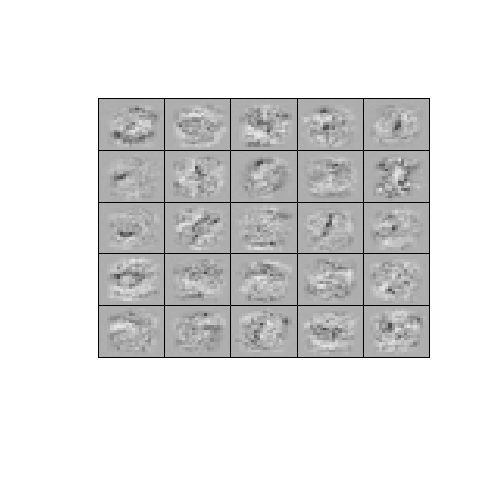

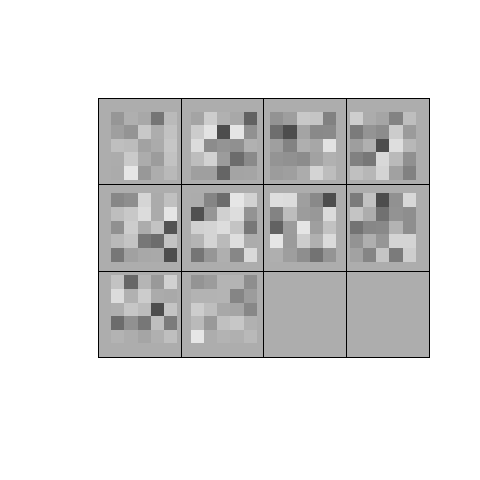

In [202]:
#Ahora "visualizamos" los pesos que aprendió la red neuronal mostrando las capas ocultas para ver que están capturando en
#los datos
displayData(Theta1[,2:ncol(Theta1)])
displayData(Theta2[,2:ncol(Theta2)])

In [203]:
#Calculamos la precisión de la red

predict <- function(Theta1, Theta2, X) {
    
    m <- nrow(X)
    num_labels <- nrow(Theta2)
    
    p <- rep(0, m)
    
    h1 <- sigmoid(cbind(1, X) %*% t(Theta1))
    h2 <- sigmoid(cbind(1, h1) %*% t(Theta2))
    
    p <- apply(h2, 1, which.max)
    p
}

pred <- predict(Theta1, Theta2, X)

cat("Precisión en el dataset de entrenamiento: ", mean(pred == y) * 100)

Precisión en el dataset de entrenamiento:  99.64